In [3]:
import os 
from dotenv import load_dotenv
load_dotenv()
NIXTLA_API = os.getenv("NIXTLA_API")

In [4]:
from nixtla import NixtlaClient

nixtla_client = NixtlaClient(
    api_key= NIXTLA_API
)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv('NEPSE.csv')

In [17]:
pd.concat([df.head(), df.tail()])

,open,high,low,close,volume,date
0,262.52,262.52,262.52,262.52,2.630000e+02,1999-12-31 05:45:00
1,262.50,262.50,262.50,262.50,2.630000e+02,2000-01-03 05:45:00
2,262.94,262.94,262.94,262.94,2.630000e+02,2000-01-04 05:45:00
3,264.52,264.52,264.52,264.52,2.650000e+02,2000-01-05 05:45:00
4,265.76,265.76,265.76,265.76,2.660000e+02,2000-01-06 05:45:00
5901,2603.47,2629.26,2599.72,2600.53,5.767895e+09,2025-06-24 20:45:00
5902,2601.11,2607.71,2594.34,2600.20,5.942852e+09,2025-06-25 20:45:00
5903,2599.70,2617.65,2594.71,2595.74,7.780242e+09,2025-06-26 20:45:00
5904,2594.94,2626.21,2594.23,2622.28,7.121736e+09,2025-06-29 20:45:00
5905,2627.93,2636.71,2627.31,2635.73,3.339136e+08,2025-06-30 16:59:10


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5906 entries, 0 to 5905
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    5906 non-null   float64
 1   high    5906 non-null   float64
 2   low     5906 non-null   float64
 3   close   5906 non-null   float64
 4   volume  5906 non-null   float64
 5   date    5906 non-null   object 
dtypes: float64(5), object(1)
memory usage: 277.0+ KB


In [8]:
df.describe()

,open,high,low,close,volume
count,5906.000000,5906.000000,5906.000000,5906.000000,5.906000e+03
mean,998.300339,1003.640943,992.195976,997.522330,1.057696e+09
std,775.645964,783.100686,766.566751,774.111072,2.718469e+09
min,186.220000,186.220000,186.220000,186.220000,0.000000e+00
25%,348.520000,348.520000,348.520000,348.520000,3.200000e+02
50%,718.355000,718.355000,718.355000,718.355000,5.800000e+02
75%,1467.401665,1477.430000,1458.120000,1466.487500,4.746687e+08
max,3208.530760,3227.110000,3178.250000,3198.602290,2.995852e+10


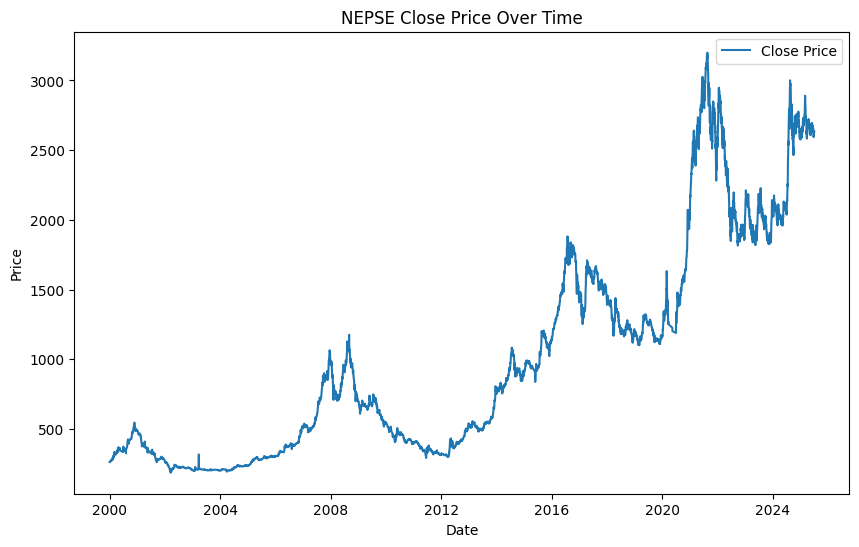

In [13]:
fig = plt.figure(figsize=(10, 6))
df['date'] = pd.to_datetime(df['date'])
plt.plot(df['date'], df['close'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Price') 
plt.title('NEPSE Close Price Over Time')
plt.legend()    

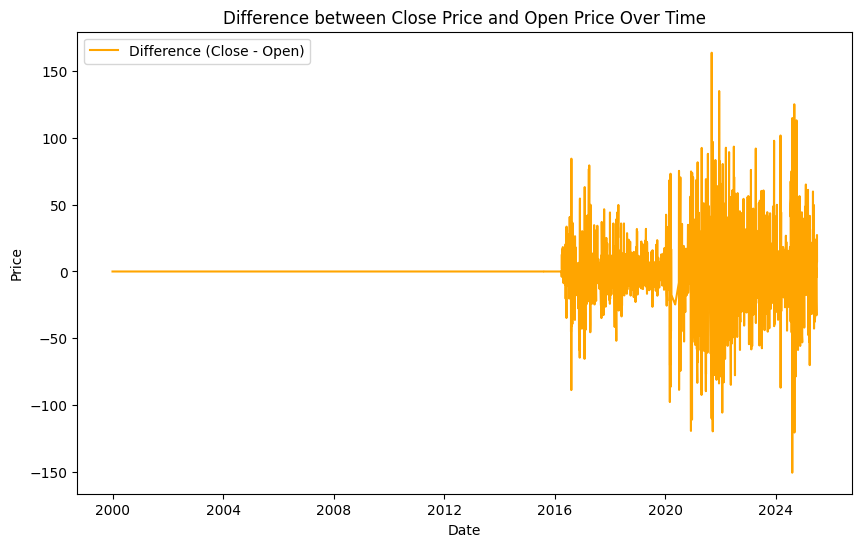

In [15]:
fig = plt.figure(figsize=(10, 6))
df['date'] = pd.to_datetime(df['date'])

plt.plot(df['date'], df['close'] - df['open'], label='Difference (Close - Open)', color='orange')
plt.xlabel('Date')
plt.ylabel('Price') 
plt.title('Difference between Close Price and Open Price Over Time')
plt.legend()

In [21]:
df_nixtla = pd.DataFrame({
    'unique_id': 'NEPSE',
    'ds': pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d'),
    'y': df['close'],
    'open': df['open'],
    'high': df['high'], 
    'low': df['low'],
    'volume': df['volume']
})
df_nixtla.head()

,unique_id,ds,y,open,high,low,volume
0,NEPSE,1999-12-31,262.52,262.52,262.52,262.52,263.0
1,NEPSE,2000-01-03,262.50,262.50,262.50,262.50,263.0
2,NEPSE,2000-01-04,262.94,262.94,262.94,262.94,263.0
3,NEPSE,2000-01-05,264.52,264.52,264.52,264.52,265.0
4,NEPSE,2000-01-06,265.76,265.76,265.76,265.76,266.0


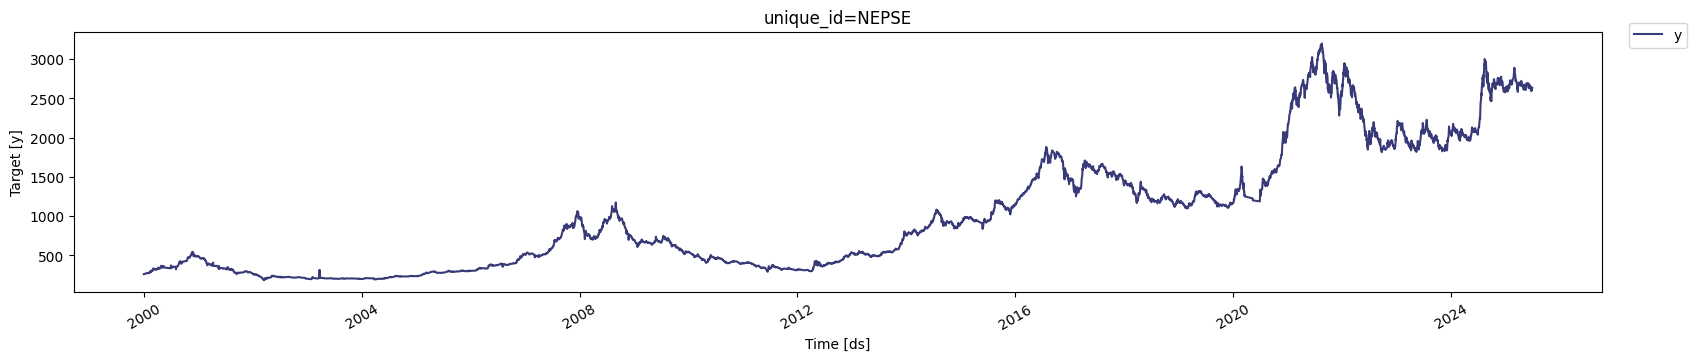

In [26]:
nixtla_client.plot(df_nixtla)

In [35]:
df_nixtla['ds'].nunique(), df_nixtla.shape[0]

(5901, 5901)

In [36]:
df_nixtla['ds'].isnull().sum(), df_nixtla['y'].isnull().sum()

(np.int64(0), np.int64(0))

In [33]:
# Create custom business day for Nepal (Sunday-Friday)
nepal_weekmask = 'Sun Mon Tue Wed Thu Fri'  # Nepal market days
nepal_bday = pd.offsets.CustomBusinessDay(weekmask=nepal_weekmask)

In [40]:
# Drop any rows with NaN values and sort by date
df_nixtla = df_nixtla.dropna().sort_values('ds')

# Create a complete date range with Nepal business days
date_range = pd.date_range(
    start=df_nixtla['ds'].min(),
    end=df_nixtla['ds'].max(),
    freq=nepal_bday
)

# Reindex the dataframe to fill missing dates
df_nixtla = df_nixtla.set_index('ds').reindex(date_range)
df_nixtla['unique_id'] = df_nixtla['unique_id'].fillna('NEPSE')

# Forward fill missing values
# df_nixtla = df_nixtla.fillna(method='ffill')

# Reset index to get ds as a column
df_nixtla = df_nixtla.reset_index().rename(columns={'index': 'ds'})

# For daily stock market data (business days only)
forecast = nixtla_client.forecast(
    df=df_nixtla,
    h=30,
    freq=nepal_bday,  # Business day frequency
    level=[80, 90]
)

INFO:nixtla.nixtla_client:Validating inputs...
e:\FYP\FYP\Lib\site-packages\nixtla\nixtla_client.py:380: UserWarning: `df` contains the following exogenous features: ['open', 'high', 'low', 'volume'], but `X_df` was not provided and they were not declared in `hist_exog_list`. They will be ignored.
  warnings.warn(
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [44]:
pd.concat([forecast.head(), forecast.tail()])

,unique_id,ds,TimeGPT,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-80,TimeGPT-lo-90
0,NEPSE,2025-07-01,2636.5981,2644.5403,2646.1233,2628.6560,2627.0730
1,NEPSE,2025-07-02,2633.2954,2668.3862,2671.9434,2598.2046,2594.6475
2,NEPSE,2025-07-03,2631.8780,2666.2578,2669.0251,2597.4980,2594.7307
3,NEPSE,2025-07-04,2632.2202,2668.3790,2670.9421,2596.0615,2593.4983
4,NEPSE,2025-07-06,2632.7350,2665.4910,2666.9692,2599.9792,2598.5010
25,NEPSE,2025-07-30,2641.9583,2694.1860,2699.3625,2589.7305,2584.5540
26,NEPSE,2025-07-31,2641.1646,2690.1182,2698.8767,2592.2110,2583.4524
27,NEPSE,2025-08-01,2641.0073,2688.3328,2697.1710,2593.6820,2584.8438
28,NEPSE,2025-08-03,2640.6912,2672.4697,2676.1885,2608.9126,2605.1938
29,NEPSE,2025-08-04,2641.2336,2665.6863,2666.6677,2616.7810,2615.7996


In [38]:
anomalies_df = nixtla_client.detect_anomalies(df_nixtla, target_col='y', time_col='ds', id_col='unique_id')

nixtla_client.plot(
df_nixtla,
anomalies_df,
plot_anomalies=True
)

INFO:nixtla.nixtla_client:Validating inputs...


RuntimeError: Could not infer the frequency of the time column. This could be due to inconsistent intervals. Please check your data for missing, duplicated or irregular timestamps